[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tryolabs/fashion-assistant/blob/main/simple_agent.ipynb)

In [1]:
!pip -q install llama-index python-dotenv llama-hub pyowm deeplake

In [2]:
!rm -rf fashion-assistant/
!rm -rf src/
!rm -rf assets/
!git clone https://github.com/tryolabs/fashion-assistant && mv fashion-assistant/src . && mv fashion-assistant/assets .

Cloning into 'shopping-assistant'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (58/58), done.
remote: Total 82 (delta 28), reused 74 (delta 21), pack-reused 0
Receiving objects: 100% (82/82), 2.98 MiB | 6.21 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [3]:
import os
from getpass import getpass

def get_and_set_env(name):

  secret = getpass(f"Enter {name}")
  os.environ[name] = secret


os.environ["ACTIVELOOP_DATASET_TEXT"] = "hub://genai360/walmart-descriptions"
os.environ["ACTIVELOOP_DATASET_IMG"] = "hub://genai360/walmart-images"

In [4]:
get_and_set_env("OPENAI_API_KEY")

Enter OPENAI_API_KEY··········


In [5]:
get_and_set_env("OPEN_WEATHER_MAP_KEY")

Enter OPEN_WEATHER_MAP_KEY··········


In [17]:
import deeplake
from PIL import Image
from llama_index.agent import OpenAIAgent
from llama_index.llms import OpenAI

from src.main import inventory_query_engine_tool, outfit_description_tool

In [14]:
ds = deeplake.load('hub://genai360/walmart-images')

/

Opening dataset in read-only mode as you don't have write permissions.


|

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/genai360/walmart-images



|

hub://genai360/walmart-images loaded successfully.



In [22]:
!mkdir -p input_image/
img = Image.fromarray(ds.images[0].numpy())
img.save("input_image/example.png")

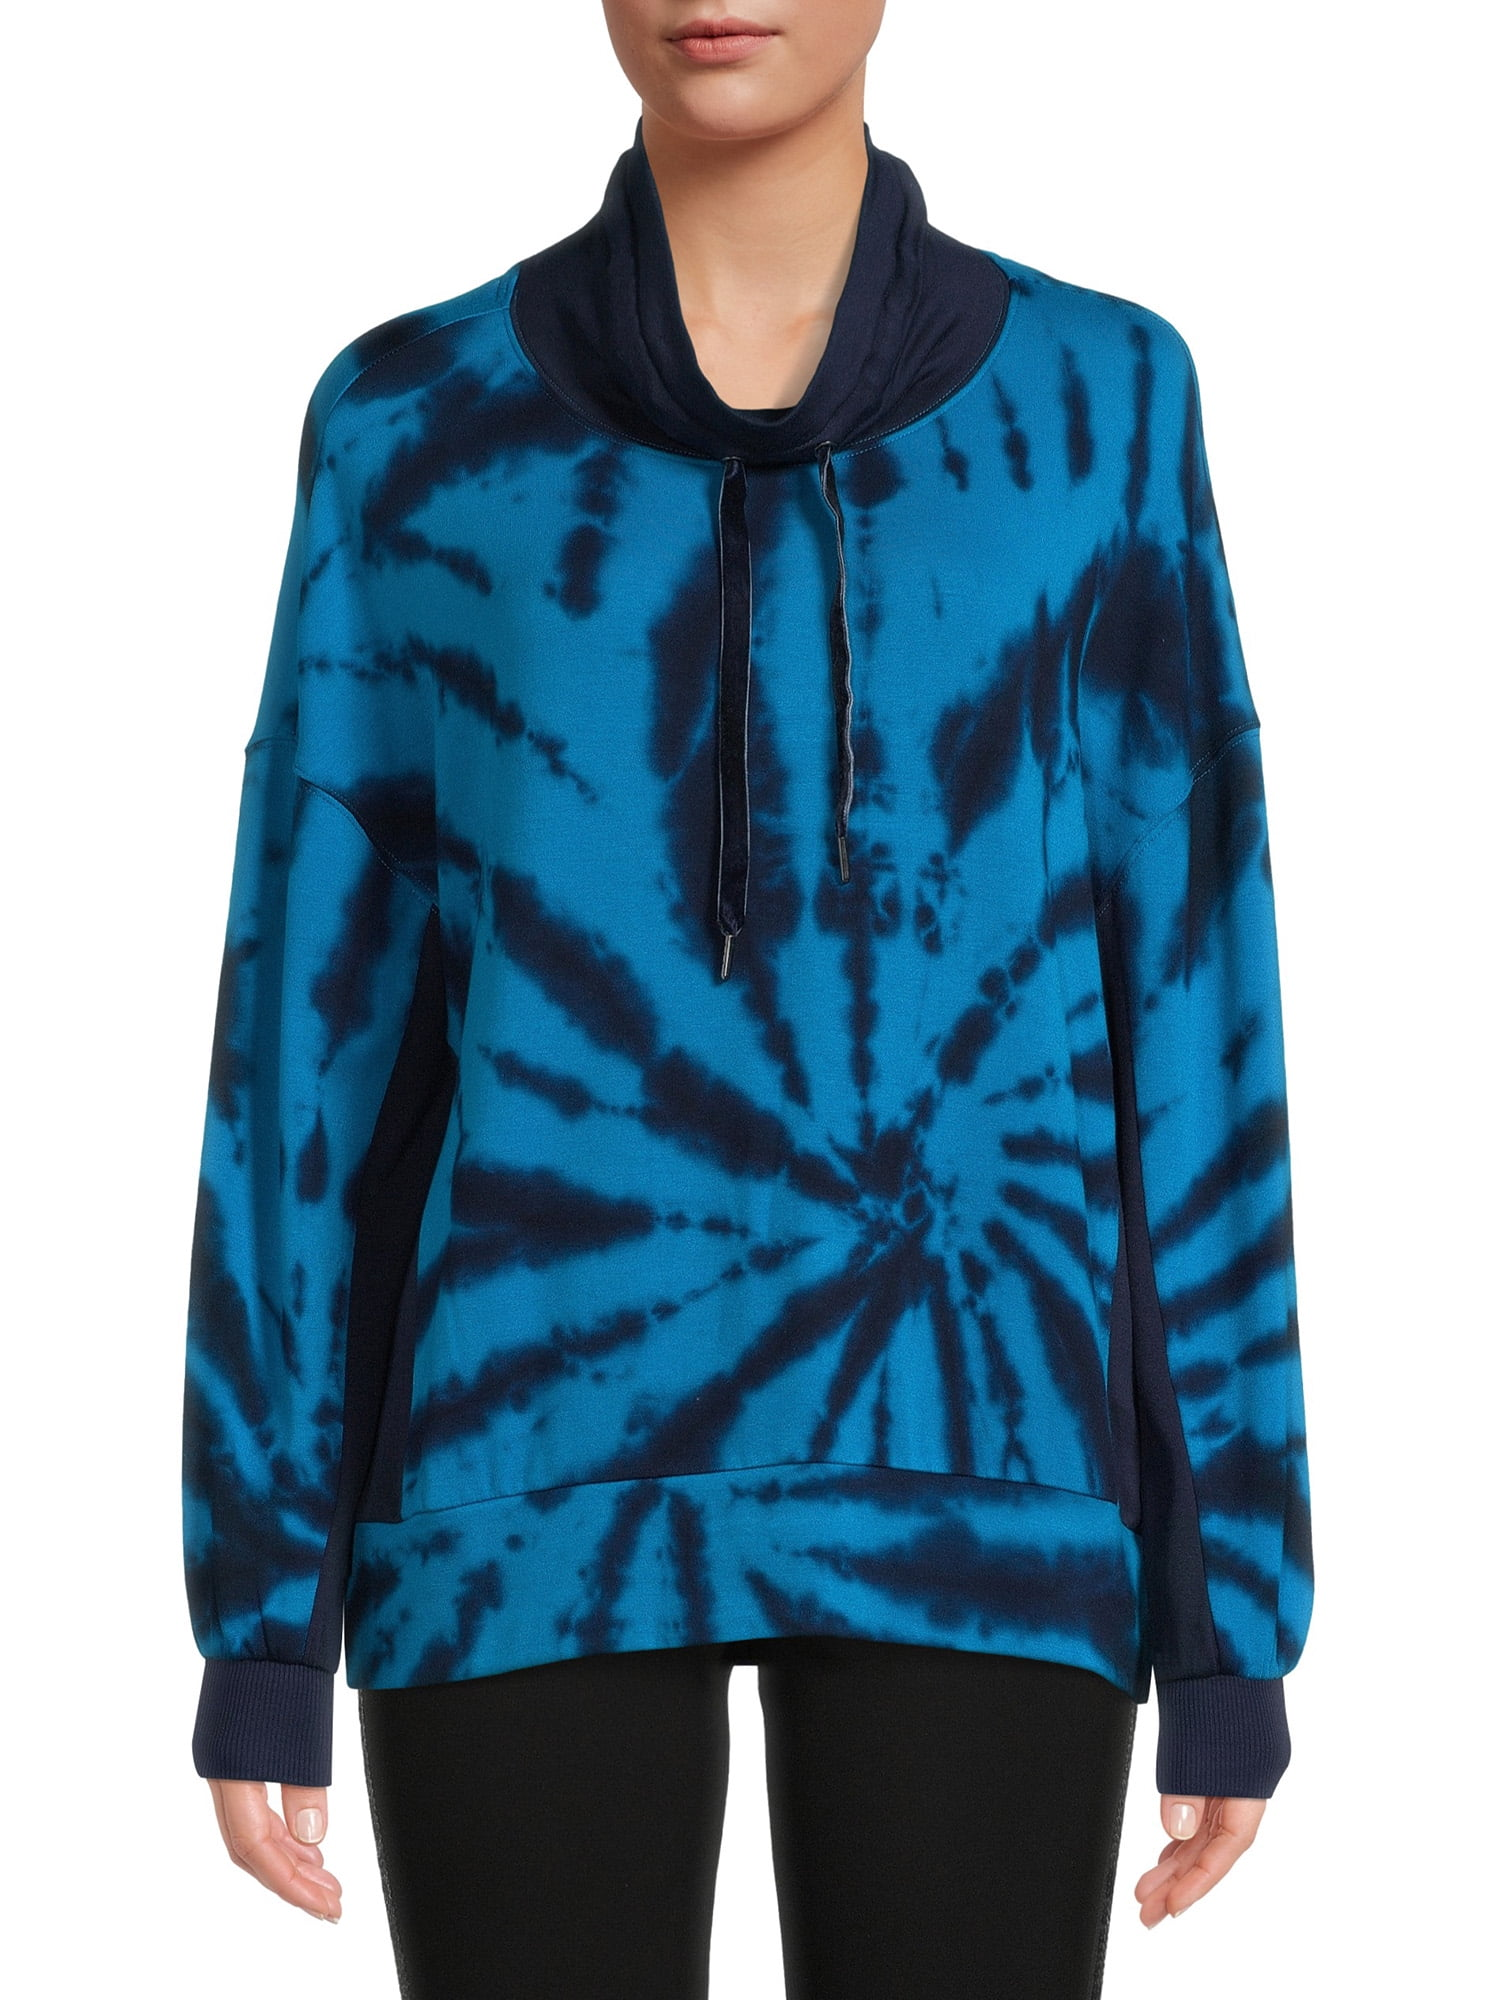

In [23]:
img

In [24]:
llm = OpenAI(model="gpt-4", temperature=0.2)

agent = OpenAIAgent.from_tools(
    system_prompt="""
    You are a specialized fashion assistant.

    Customers will provide you with a piece of clothing, and you will generate a matching outfit.

    Always remember to ask for the user gender.

    Your final answer needs to be the product_id associated with the best matching product in our inventory.

    For each product of the outfit, search the inventory.

    Incldue the total price of the recommended outfit.
    """,
    tools=[
        inventory_query_engine_tool,
        outfit_description_tool,
    ],
    llm=llm,
    verbose=True,
)

In [25]:
r = agent.chat("Hi")
print(r)

STARTING TURN 1
---------------

Hello! How can I assist you today?


In [26]:
r = agent.chat("What are your tools?")
print(r)

STARTING TURN 1
---------------

As a shopping assistant, I have two main tools at my disposal:

1. **Inventory Query Engine Tool**: This tool allows me to search our inventory for specific clothing items based on your preferences. For example, if you tell me you're looking for a red dress, I can use this tool to find all the red dresses in our inventory.

2. **Outfit Description Generator**: This tool helps me generate a complete outfit based on your preferences and gender. For example, if you tell me you're a woman who prefers casual wear, I can use this tool to generate a casual outfit for you.

These tools help me provide you with personalized shopping assistance. How can I assist you further?


In [27]:
r = agent.chat("I want an outfit for a casual birthday party")
print(r)

STARTING TURN 1
---------------

Sure, I can help with that. Could you please tell me your gender? This will help me generate the most suitable outfit for you.


In [28]:
r = agent.chat("I'm a woman")
print(r)

STARTING TURN 1
---------------

=== Calling Function ===
Calling function: generate_outfit_description with args: {
"gender": "female",
"user_input": "casual birthday party"
}
Got output: top='' bottom='A pair of high-waisted, light-wash denim jeans with a relaxed fit to complement the casual vibe of the party.' shoes='White low-top canvas sneakers for a comfortable and stylish look that matches well with the casual theme.'

STARTING TURN 2
---------------

=== Calling Function ===
Calling function: inventory_query_engine_tool with args: {
"input": "high-waisted, light-wash denim jeans"
}
Got output: {"cloths": [{"name": "Jordache Women's High Rise Straight Jeans, Sizes 2-22", "product_id": "17PJXWW5WIXH", "price": 14.0}, {"name": "Terra & Sky Women's Plus Size High Waist Bootcut Jeans", "product_id": "2W4PNKKNW6NS", "price": 22.98}]}

STARTING TURN 3
---------------

=== Calling Function ===
Calling function: inventory_query_engine_tool with args: {
"input": "White low-top canvas sne